# Inference and Validation
Now that you have a trained network, you can use it for making $predictions$. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform too well on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. 
To **test for overfitting** while training, we measure the performance on data not in the training set called the **validation set**. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. 

**how to do this in PyTorch**
   * Start by loading the dataset through torchvision.This time we'll be taking advantage of the test set which you can get by setting train=False here:

    testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
    
The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Build Network Model

In [2]:

from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

**Note** 
* The goal of validation is to measure the model's performance on data that isn't part of the training set. (Peformance is based on the developer,but mostly its accuracy)
* We'll focus on accuracy here.
    * First forward pass with one batch from the test set.

In [3]:

model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


**ps.topk** method **returns probabilities and class**
ps.topk(1). This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [4]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[5],
        [3],
        [3],
        [3],
        [5],
        [5],
        [5],
        [3],
        [3],
        [3]])


## Check if predicted classes match the label

This is simple to do by **equating top_class and labels**, but we have to **be careful of the shapes.**  
$Example:$
top_class is a 2D tensor with shape (64, 1)
labels is 1D with shape (64)
To get the equality to work out use the below code


In [5]:
equals = top_class == labels.view(*top_class.shape)

## calculate the percentage of correct predictions
equals has binary values, either 0 or 1.This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. 

TO DO THIS
* Convert equals to a float tensor
**Note** that when we take **torch.mean** it returns a **scalar tensor**, to get the **actual value as a float we'll need to do accuracy.item().**

In [6]:

accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 3.125%


 Currently the network is untrained ,so accuracy is about 10%

## Lets Train the Network and Include Validation pass
so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up the by turning off gradients using torch.no_grad():

````
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
````

### Exercise 1:
Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        
        ## TODO: Implement the validation pass and print out the validation accuracy
        
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader: 
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
        '''                
                ps = torch.exp(model(images))
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                
        print(f'Accuracy: {accuracy.item()*100}%')
        '''


Epoch: 1/30..  Training Loss: 0.514..  Test Loss: 0.444..  Test Accuracy: 0.836
Epoch: 2/30..  Training Loss: 0.393..  Test Loss: 0.380..  Test Accuracy: 0.863
Epoch: 3/30..  Training Loss: 0.352..  Test Loss: 0.393..  Test Accuracy: 0.863
Epoch: 4/30..  Training Loss: 0.329..  Test Loss: 0.379..  Test Accuracy: 0.865
Epoch: 5/30..  Training Loss: 0.313..  Test Loss: 0.389..  Test Accuracy: 0.863
Epoch: 6/30..  Training Loss: 0.301..  Test Loss: 0.365..  Test Accuracy: 0.872
Epoch: 7/30..  Training Loss: 0.290..  Test Loss: 0.389..  Test Accuracy: 0.861
Epoch: 8/30..  Training Loss: 0.280..  Test Loss: 0.401..  Test Accuracy: 0.865
Epoch: 9/30..  Training Loss: 0.271..  Test Loss: 0.395..  Test Accuracy: 0.875
Epoch: 10/30..  Training Loss: 0.263..  Test Loss: 0.369..  Test Accuracy: 0.878
Epoch: 11/30..  Training Loss: 0.254..  Test Loss: 0.374..  Test Accuracy: 0.871
Epoch: 12/30..  Training Loss: 0.251..  Test Loss: 0.384..  Test Accuracy: 0.874
Epoch: 13/30..  Training Loss: 0.244.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

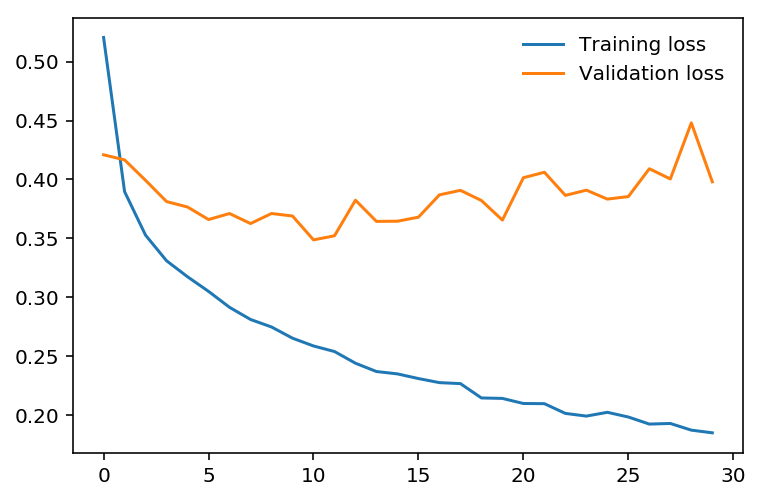

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

I the above plot....
If we look at the training and validation losses as we train the network, we can see a phenomenon known as **overfitting**.
We see two things happening
* The network learns the training set better and better, resulting in lower training losses. 
* However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing.

## Overfitting

The **ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible.**

### Option 1 : "  Early Stopping " 
To use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called **early-stopping.** In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

### Option 2 : "  Dropout "
The most common method to reduce overfitting (outside of early-stopping) is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the **nn.Dropout** module.


In [9]:
# Dropout 

# build classifer 
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output or last layer - so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

**Note:**
   * During **training** we want to **use dropout** to prevent overfitting
   * During **inference** use the **entire network**.
        *  turn off dropout during validation, testing ,whenever we're using the network to make predictions
        * use **model.eval()**  - This sets the model to evaluation mode where the dropout probability is 0.
        * use **model.train()** - to turn the dropout back on ,by setting the model to train mode.

### Pattern for validation loop
* turn off gradients, 
* set the model to evaluation mode, 
* calculate the validation loss and metric, 
* set the model back to train mode.

````
# turn off gradients
with torch.no_grad():

    # set model to evaluation mode
    model.eval()

    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
````


### Exercise 2:
Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

## TODO: Define your model with dropout added

In [10]:
# Dropout 

# build classifer 
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output or last layer - so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy

In [11]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        
       ## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
        test_loss = 0
        accuracy = 0
        # turn off gradients
        with torch.no_grad():
            
            # set model to evaluation mode
            model.eval()
            
            # validation pass here
            for images, labels in testloader: 
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # set model back to train mode
        model.train()            
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        


        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.601..  Test Loss: 0.455..  Test Accuracy: 0.833
Epoch: 2/30..  Training Loss: 0.478..  Test Loss: 0.433..  Test Accuracy: 0.842
Epoch: 3/30..  Training Loss: 0.449..  Test Loss: 0.415..  Test Accuracy: 0.849
Epoch: 4/30..  Training Loss: 0.430..  Test Loss: 0.391..  Test Accuracy: 0.860
Epoch: 5/30..  Training Loss: 0.422..  Test Loss: 0.410..  Test Accuracy: 0.851
Epoch: 6/30..  Training Loss: 0.410..  Test Loss: 0.427..  Test Accuracy: 0.847
Epoch: 7/30..  Training Loss: 0.405..  Test Loss: 0.393..  Test Accuracy: 0.859
Epoch: 8/30..  Training Loss: 0.396..  Test Loss: 0.400..  Test Accuracy: 0.862
Epoch: 9/30..  Training Loss: 0.400..  Test Loss: 0.388..  Test Accuracy: 0.859
Epoch: 10/30..  Training Loss: 0.391..  Test Loss: 0.399..  Test Accuracy: 0.858
Epoch: 11/30..  Training Loss: 0.379..  Test Loss: 0.410..  Test Accuracy: 0.855
Epoch: 12/30..  Training Loss: 0.381..  Test Loss: 0.368..  Test Accuracy: 0.870
Epoch: 13/30..  Training Loss: 0.380.

In [12]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

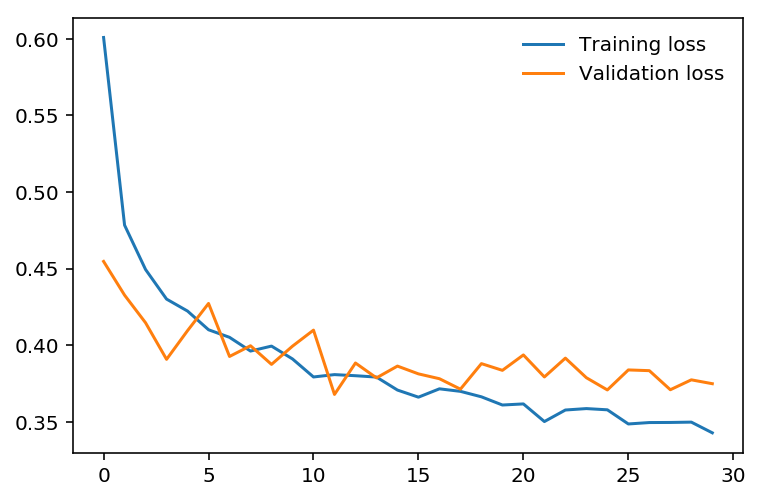

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference
Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with model.eval(). You'll also want to turn off autograd with the torch.no_

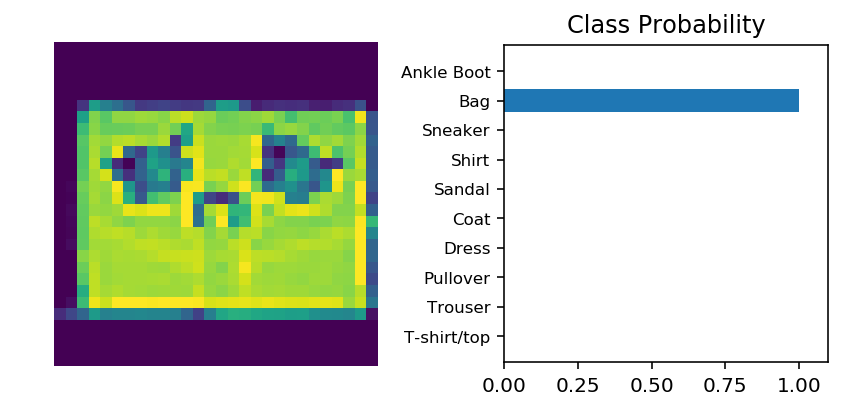

In [14]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')